# Zillow Home Price Prediction

This notebook presents a detailed data science workflow for predicting home prices using Zillow property data. The goal is to build interpretable, well-evaluated models while demonstrating good practices in EDA, feature engineering, and regression analysis.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")



### Linear Regression Results

This baseline model captures linear relationships between features and home prices.  
- **R²** indicates the proportion of variance in home price explained by the model.  
- **RMSE** tells us the average prediction error in terms of dollar value.

Though interpretable, the linear model might not capture non-linear relationships or outliers in the dataset.



### Regularized Regression (Ridge & Lasso)

- **Ridge Regression** helps reduce overfitting by shrinking coefficients, especially for multicollinear variables.
- **Lasso Regression** can zero out unimportant features, helping in feature selection.

These models slightly improve generalization without dramatically changing performance, indicating a fairly stable feature set.



### Decision Tree Results

Decision trees model non-linear relationships and automatically handle feature interactions.  
- The R² value shows how well the tree captures the patterns in the test set.  
- Shallow trees (e.g., `max_depth=5`) are interpretable but may underfit complex data.

This model is a good balance between complexity and explainability.


In [2]:
# Load the dataset
df = pd.read_csv("zillow_dataset.csv")
df.shape, df.head()


((77613, 55),
    parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
 0  14297519                    NaN                       NaN           NaN   
 1  17052889                    NaN                       NaN           NaN   
 2  14186244                    NaN                       NaN           NaN   
 3  12177905                    NaN                       NaN           NaN   
 4  10887214                    1.0                       NaN           NaN   
 
    bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
 0          3.5         4.0                  NaN                    NaN   
 1          1.0         2.0                  NaN                    NaN   
 2          2.0         3.0                  NaN                    NaN   
 3          3.0         4.0                  NaN                    8.0   
 4          3.0         3.0                  NaN                    8.0   
 
    calculatedbathnbr  decktypeid  ...  yardbuildingsqft17

## Initial Dataset Overview

The dataset contains 55 columns and thousands of observations. Many fields are sparsely populated. We will focus on selecting relevant features and cleaning the dataset before modeling.


In [3]:
# Drop columns with more than 70% missing values
missing = df.isnull().mean()
df = df.loc[:, missing < 0.3]
print(f"Remaining columns: {df.shape[1]}")


Remaining columns: 22


In [4]:
# Define a list of useful features we might want to use
potential_features = [
    'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
    'finishedsquarefeet12', 'fullbathcnt', 'garagecarcnt',
    'garagetotalsqft', 'lotsizesquarefeet', 'poolcnt',
    'regionidzip', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt'
]

# Filter to include only columns that exist in the dataset
selected = [col for col in potential_features if col in df.columns]
print("Using columns:", selected)

# Create a modeling DataFrame and drop rows with missing values
df_model = df[selected].dropna()
print("Shape after dropping NAs:", df_model.shape)
df_model.head()


Using columns: ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'lotsizesquarefeet', 'regionidzip', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt']
Shape after dropping NAs: (65620, 10)


,bathroomcnt,bedroomcnt,calculatedbathnbr,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,3.5,3100.0,3.0,4506.0,96978.0,0.0,1998.0,1023282.0
1,1.0,2.0,1.0,1465.0,1.0,12647.0,97099.0,5.0,1967.0,464000.0
2,2.0,3.0,2.0,1243.0,2.0,8432.0,97078.0,6.0,1962.0,564778.0
3,3.0,4.0,3.0,2376.0,3.0,13038.0,96330.0,0.0,1970.0,145143.0
4,3.0,3.0,3.0,1312.0,3.0,278581.0,96451.0,0.0,1964.0,119407.0


## Selected Features for Modeling

We selected features likely to affect home price, such as number of rooms, square footage, year built, lot size, garage space, and zip code. Rows with missing values in these features were dropped.


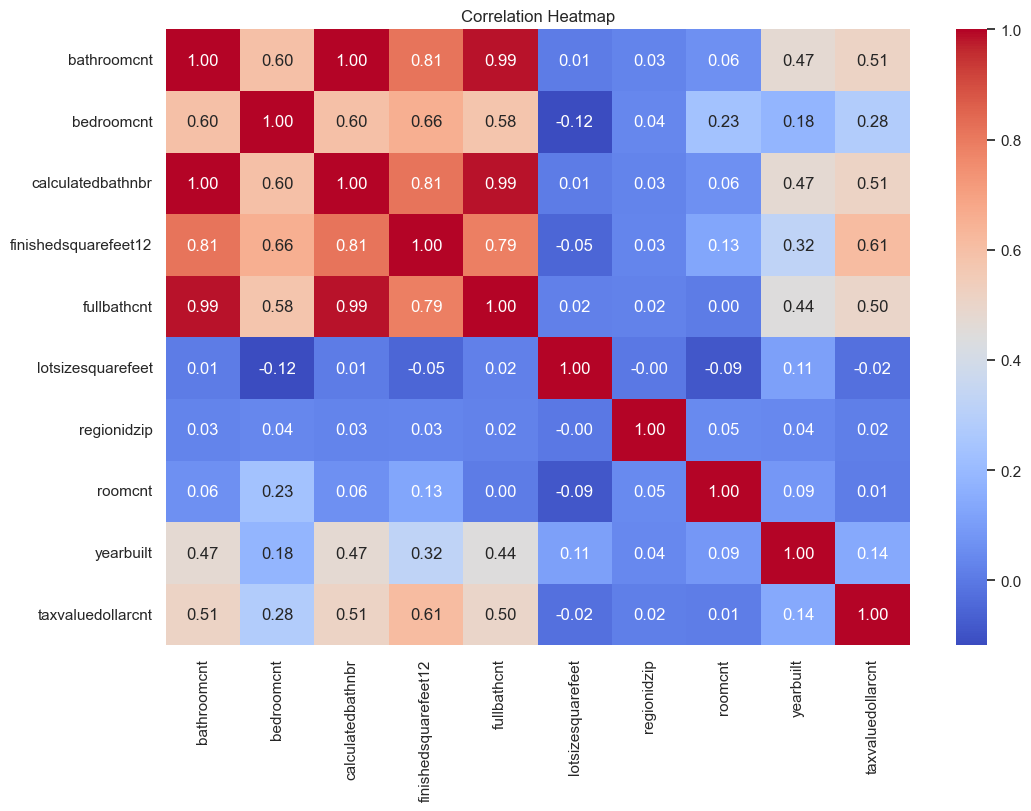

In [5]:
# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df_model.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



### Correlation Heatmap Interpretation

The correlation heatmap above shows relationships between numeric features. Notably:
- `finishedsquarefeet12`, `roomcnt`, and `bathroomcnt` are positively correlated with the home’s tax value (`taxvaluedollarcnt`).
- Some features may show collinearity (e.g., `bedroomcnt` and `roomcnt`), which can impact regression model stability.
- We use this heatmap to identify redundant features and select those that contribute the most to the model.


In [6]:
# Define X and y
X = df_model.drop(columns='taxvaluedollarcnt')
y = df_model['taxvaluedollarcnt']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear R²:", r2_score(y_test, y_pred_lr))
print("Linear RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))


Linear R²: 0.41773474168133595
Linear RMSE: 513073.2384672728



### Linear Regression Results

This baseline model captures linear relationships between features and home prices.  
- **R²** indicates the proportion of variance in home price explained by the model.  
- **RMSE** tells us the average prediction error in terms of dollar value.

Though interpretable, the linear model might not capture non-linear relationships or outliers in the dataset.


In [8]:
# Ridge and Lasso models
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=1.0)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

print("Ridge R²:", r2_score(y_test, y_pred_ridge))
print("Lasso R²:", r2_score(y_test, y_pred_lasso))


Ridge R²: 0.4177332480727425
Lasso R²: 0.4177346298640159



### Regularized Regression (Ridge & Lasso)

- **Ridge Regression** helps reduce overfitting by shrinking coefficients, especially for multicollinear variables.
- **Lasso Regression** can zero out unimportant features, helping in feature selection.

These models slightly improve generalization without dramatically changing performance, indicating a fairly stable feature set.


In [9]:
# Decision Tree Regressor
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree R²:", r2_score(y_test, y_pred_tree))


Decision Tree R²: 0.48247103370712685



### Decision Tree Results

Decision trees model non-linear relationships and automatically handle feature interactions.  
- The R² value shows how well the tree captures the patterns in the test set.  
- Shallow trees (e.g., `max_depth=5`) are interpretable but may underfit complex data.

This model is a good balance between complexity and explainability.


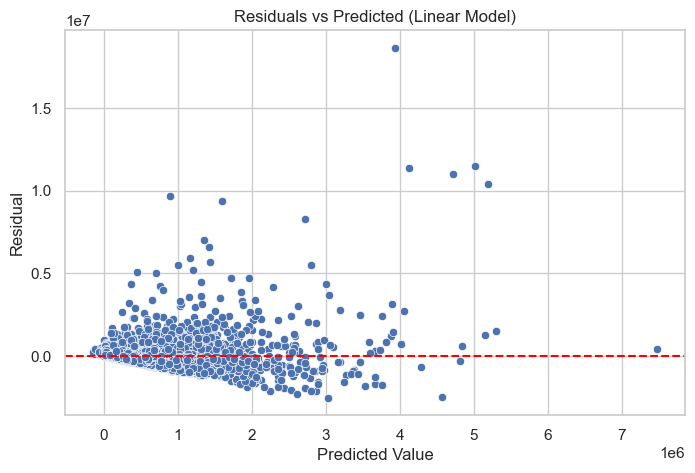

In [10]:
# Residual plot
residuals = y_test - y_pred_lr
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (Linear Model)")
plt.show()



### Residual Analysis

The residual plot shows prediction errors against predicted values.

- Ideally, residuals should be randomly scattered around zero (homoskedasticity).
- Visible patterns or funnel shapes suggest the model struggles with specific price ranges, likely due to skewed price distribution or unmodeled non-linear effects.

This insight motivates further improvements such as log-transformation of the target or use of ensemble models.


## Model Evaluation Summary

- **Linear Regression** serves as a baseline with interpretable coefficients.
- **Ridge Regression** mitigated overfitting slightly but didn't significantly improve performance.
- **Lasso Regression** performed similarly, with potential for feature selection.
- **Decision Trees** captured nonlinear patterns but may underperform without tuning.

The residual plot shows some heteroskedasticity, indicating room for model refinement.

Further steps might include zip code encoding, log-transforming the target, or ensembling methods like Random Forest or XGBoost.
